<a href="https://colab.research.google.com/github/harrymkwn/InfluenceAnalysis/blob/master/AllEmointGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from google.colab import  drive
drive.mount('/content/drive')
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
device_name = tf.test.gpu_device_name()
print(device_name)
df = pd.read_csv('/content/drive/MyDrive/InfluenceAnalysis/Data/Tweets_clean_data.csv')
df = df.sample(frac=1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/device:GPU:0


In [ ]:
category_dict = {"anger":[1,0,0,0],"sadness":[0,1,0,0],"fear":[0,0,1,0],"joy":[0,0,0,1]}
data_tweet = [x.lower().split() for x in df['Tweet']]
data_cat = np.array([category_dict[x] for x in df['Emotion']])

In [ ]:
print(data_tweet[:5])
print(data_cat[:5])

[['i', 'can', 'definitely', 'feel', 'my', 'irritation', 'today', 'lord', 'give', 'me', 'strength'], ['nit', 'is', 'always', 'fun', 'to', 'anger', 'all', 'the', 'old', 'dudes', 'with', 'rock', 'n', 'roll', 'happy', 'face', 'or', 'smileyconfusion'], ['thenicebot', 'indymn', 'i', 'thought', 'the', 'holidays', 'could', 'not', 'get', 'any', 'more', 'cheerful', 'and', 'then', 'i', 'met', 'you', 'the', 'nice', 'bot', 'الخفجي'], ['yes', 'it', 'is', 'shocking', 'how', 'islamophobic', 'indias', 'are', 'considering', 'how', 'many', 'muslims', 'live', 'there'], ['watch', 'this', 'amazing', 'live', 'ly', 'broadcast', 'by', 'musically']]
[[1 0 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 0 1]]


In [ ]:
# Parameters
Min_count = 0
Embedding_size = 100
Window_size = 5
Negative_sampling = 00

In [ ]:
w2v_sg = Word2Vec(min_count=Min_count,
                     window=Window_size,
                     size=Embedding_size,
                     negative=Negative_sampling,sg=1)
w2v_sg.build_vocab(data_tweet)
w2v_sg.train(data_tweet, total_examples=w2v_sg.corpus_count, epochs=5)
w2v_cbow = Word2Vec(min_count=Min_count,
                     window=Window_size,
                     size=Embedding_size,
                     negative=Negative_sampling,sg=0)
w2v_cbow.build_vocab(data_tweet)
w2v_cbow.train(data_tweet, total_examples=w2v_cbow.corpus_count, epochs=5)
w2v_sg.wv.init_sims(True)
w2v_cbow.wv.init_sims(True)

In [ ]:
vocab_sg = w2v_sg.wv.vocab
vocab_sg = [x for x in vocab_sg]
vocab_cbow = w2v_cbow.wv.vocab
vocab_cbow = [x for x in vocab_cbow] 
vocab_glove = {}
with open("/content/drive/My Drive/InfluenceAnalysis/glove/glove.twitter.27B.100d.txt", 'r', encoding="utf-8") as f:
  for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      vocab_glove[word] = vector

In [ ]:
batch_size = 100
Max_input_size = max([len(x) for x in data_tweet])


In [ ]:
def vec_gen(w2v,vocab,data_tweet,data_cat,batch_size,Max_input_size,Embedding_size):
  while True:
    for k in range(int(len(data_tweet)/batch_size)):
      temp = np.array([np.array([w2v.wv.get_vector(i) for i in x if i in vocab]) for x in data_tweet[k*(batch_size):(k+1)*(batch_size)]])
      temp = np.array([np.pad(x.flatten(),(0,Max_input_size*Embedding_size-len(x.flatten()))).reshape(Max_input_size,Embedding_size) for x in temp])
      tempres = data_cat[k*(batch_size):(k+1)*(batch_size)]
      yield (temp,tempres)

def glove_gen(vocab,data_tweet,data_cat,batch_size,Max_input_size,Embedding_size=100):
  while True:
    for k in range(int(len(data_tweet)/batch_size)):
      temp = np.array([np.array([vocab[i] for i in x if i in vocab.keys()]) for x in data_tweet[k*(batch_size):(k+1)*(batch_size)]])
      temp = np.array([np.pad(x.flatten(),(0,Max_input_size*Embedding_size-len(x.flatten()))).reshape(Max_input_size,Embedding_size) for x in temp])
      tempres = data_cat[k*(batch_size):(k+1)*(batch_size)]
      yield (temp,tempres)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_tweet, data_cat, test_size=0.30, random_state=42)
result_table = [0,0,0,0,0,0,0,0,0]

In [ ]:
epochs = 50

In [ ]:
model_sg = tf.keras.Sequential()
model_sg.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg.add(tf.keras.layers.LSTM(50))
model_sg.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_sg_lstm = model_sg.fit_generator(generator = vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_sg.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[0]=history[1]
print("SG_LSTM")


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
49/49 [==============================] - 3s 54ms/step - loss: 1.3787 - accuracy: 0.3051
Epoch 2/50
49/49 [==============================] - 3s 54ms/step - loss: 1.3754 - accuracy: 0.3165
Epoch 3/50
49/49 [==============================] - 3s 55ms/step - loss: 1.3752 - accuracy: 0.3165
Epoch 4/50
49/49 [==============================] - 3s 54ms/step - loss: 1.3751 - accuracy: 0.3167
Epoch 5/50
49/49 [==============================] - 3s 53ms/step - loss: 1.3750 - accuracy: 0.3167
Epoch 6/50
49/49 [==============================] - 3s 54ms/step - loss: 1.3750 - accuracy: 0.3167
Epoch 7/50
49/49 [==============================] - 3s 55ms/step - loss: 1.3749 - accuracy: 0.3167
Epoch 8/50
49/49 [==============================] - 3s 53ms/step - loss: 1.3748 - accuracy: 0.3167
Epoch 9/50
49/49 [==============================] - 3s 53ms/step - loss: 1.3748 - accuracy: 0.3167
Epoch 10/50
49/49 [==============

In [ ]:
model_sg_bi = tf.keras.Sequential()
model_sg_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50),merge_mode='concat'))
model_sg_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_sg_bi = model_sg_bi.fit_generator(generator = vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_sg_bi.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[1]=history[1]
print("SG_BI")

Epoch 1/50
49/49 [==============================] - 3s 54ms/step - loss: 1.3753 - accuracy: 0.3131
Epoch 2/50
49/49 [==============================] - 3s 56ms/step - loss: 1.3603 - accuracy: 0.3233
Epoch 3/50
49/49 [==============================] - 3s 55ms/step - loss: 1.3317 - accuracy: 0.3708
Epoch 4/50
49/49 [==============================] - 3s 56ms/step - loss: 1.2974 - accuracy: 0.3967
Epoch 5/50
49/49 [==============================] - 3s 55ms/step - loss: 1.2690 - accuracy: 0.4131
Epoch 6/50
49/49 [==============================] - 3s 55ms/step - loss: 1.2527 - accuracy: 0.4308
Epoch 7/50
49/49 [==============================] - 3s 58ms/step - loss: 1.2310 - accuracy: 0.4429
Epoch 8/50
49/49 [==============================] - 3s 60ms/step - loss: 1.2147 - accuracy: 0.4529
Epoch 9/50
49/49 [==============================] - 3s 55ms/step - loss: 1.2050 - accuracy: 0.4561
Epoch 10/50
49/49 [==============================] - 3s 57ms/step - loss: 1.1889 - accuracy: 0.4716
Epoch 11/

In [ ]:
model_sg_rnn = tf.keras.Sequential()
model_sg_rnn.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg_rnn.add(tf.keras.layers.SimpleRNN(50))
model_sg_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_sg_rnn = model_sg_rnn.fit_generator(generator = vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_sg_rnn.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)


result_table[2]=history[1]
print("SG_RNN")

Epoch 1/50
49/49 [==============================] - 4s 82ms/step - loss: 1.3819 - accuracy: 0.2969
Epoch 2/50
49/49 [==============================] - 4s 79ms/step - loss: 1.3722 - accuracy: 0.3116
Epoch 3/50
49/49 [==============================] - 4s 83ms/step - loss: 1.3652 - accuracy: 0.3241
Epoch 4/50
49/49 [==============================] - 4s 85ms/step - loss: 1.3546 - accuracy: 0.3345
Epoch 5/50
49/49 [==============================] - 4s 80ms/step - loss: 1.3472 - accuracy: 0.3476
Epoch 6/50
49/49 [==============================] - 4s 78ms/step - loss: 1.3346 - accuracy: 0.3490
Epoch 7/50
49/49 [==============================] - 4s 77ms/step - loss: 1.3230 - accuracy: 0.3684
Epoch 8/50
49/49 [==============================] - 4s 80ms/step - loss: 1.3060 - accuracy: 0.3920
Epoch 9/50
49/49 [==============================] - 4s 81ms/step - loss: 1.2948 - accuracy: 0.3945
Epoch 10/50
49/49 [==============================] - 4s 86ms/step - loss: 1.3146 - accuracy: 0.3820
Epoch 11/

In [ ]:
model_cbow = tf.keras.Sequential()
model_cbow.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow.add(tf.keras.layers.LSTM(50))
model_cbow.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_cbow_lstm = model_cbow.fit_generator(generator = vec_gen(w2v_cbow,vocab_cbow,X_train,y_train,batch_size,Max_input_size,Embedding_size),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_cbow.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[3]=history[1]
print("CBOW_LSTM")

Epoch 1/50
49/49 [==============================] - 3s 54ms/step - loss: 1.3779 - accuracy: 0.3073
Epoch 2/50
49/49 [==============================] - 3s 54ms/step - loss: 1.3753 - accuracy: 0.3165
Epoch 3/50
49/49 [==============================] - 3s 54ms/step - loss: 1.3751 - accuracy: 0.3165
Epoch 4/50
49/49 [==============================] - 3s 52ms/step - loss: 1.3751 - accuracy: 0.3167
Epoch 5/50
49/49 [==============================] - 3s 54ms/step - loss: 1.3751 - accuracy: 0.3167
Epoch 6/50
49/49 [==============================] - 3s 55ms/step - loss: 1.3750 - accuracy: 0.3167
Epoch 7/50
49/49 [==============================] - 3s 55ms/step - loss: 1.3750 - accuracy: 0.3167
Epoch 8/50
49/49 [==============================] - 3s 54ms/step - loss: 1.3749 - accuracy: 0.3167
Epoch 9/50
49/49 [==============================] - 3s 53ms/step - loss: 1.3749 - accuracy: 0.3167
Epoch 10/50
49/49 [==============================] - 3s 56ms/step - loss: 1.3748 - accuracy: 0.3167
Epoch 11/

In [ ]:
model_cbow_bi = tf.keras.Sequential()
model_cbow_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50),merge_mode='concat'))
model_cbow_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_cbow_bi = model_cbow_bi.fit_generator(generator = vec_gen(w2v_cbow,vocab_cbow,X_train,y_train,batch_size,Max_input_size,Embedding_size),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_cbow_bi.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[4]=history[1]
print("CBOW_BI")

Epoch 1/50
49/49 [==============================] - 3s 55ms/step - loss: 1.3754 - accuracy: 0.3033
Epoch 2/50
49/49 [==============================] - 3s 57ms/step - loss: 1.3612 - accuracy: 0.3245
Epoch 3/50
49/49 [==============================] - 3s 57ms/step - loss: 1.3432 - accuracy: 0.3720
Epoch 4/50
49/49 [==============================] - 3s 57ms/step - loss: 1.3158 - accuracy: 0.3898
Epoch 5/50
49/49 [==============================] - 3s 57ms/step - loss: 1.2937 - accuracy: 0.4059
Epoch 6/50
49/49 [==============================] - 3s 57ms/step - loss: 1.2741 - accuracy: 0.4161
Epoch 7/50
49/49 [==============================] - 3s 55ms/step - loss: 1.2544 - accuracy: 0.4278
Epoch 8/50
49/49 [==============================] - 3s 57ms/step - loss: 1.2370 - accuracy: 0.4461
Epoch 9/50
49/49 [==============================] - 3s 55ms/step - loss: 1.2206 - accuracy: 0.4520
Epoch 10/50
49/49 [==============================] - 3s 55ms/step - loss: 1.2082 - accuracy: 0.4653
Epoch 11/

In [ ]:
model_cbow_rnn = tf.keras.Sequential()
model_cbow_rnn.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow_rnn.add(tf.keras.layers.SimpleRNN(50))
model_cbow_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_cbow_rnn = model_cbow_rnn.fit_generator(generator = vec_gen(w2v_cbow,vocab_cbow,X_train,y_train,batch_size,Max_input_size,Embedding_size),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_cbow_rnn.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[5]=history[1]
print("CBOW_RNN")

Epoch 1/50
49/49 [==============================] - 4s 80ms/step - loss: 1.3774 - accuracy: 0.3057
Epoch 2/50
49/49 [==============================] - 4s 82ms/step - loss: 1.3751 - accuracy: 0.3120
Epoch 3/50
49/49 [==============================] - 4s 85ms/step - loss: 1.3659 - accuracy: 0.3200
Epoch 4/50
49/49 [==============================] - 4s 83ms/step - loss: 1.3519 - accuracy: 0.3347
Epoch 5/50
49/49 [==============================] - 4s 78ms/step - loss: 1.3527 - accuracy: 0.3369
Epoch 6/50
49/49 [==============================] - 4s 81ms/step - loss: 1.3495 - accuracy: 0.3337
Epoch 7/50
49/49 [==============================] - 4s 81ms/step - loss: 1.3363 - accuracy: 0.3500
Epoch 8/50
49/49 [==============================] - 4s 85ms/step - loss: 1.3278 - accuracy: 0.3661
Epoch 9/50
49/49 [==============================] - 4s 77ms/step - loss: 1.3164 - accuracy: 0.3661
Epoch 10/50
49/49 [==============================] - 4s 80ms/step - loss: 1.2987 - accuracy: 0.3996
Epoch 11/

In [ ]:
model_glove = tf.keras.Sequential()
model_glove.add(tf.keras.Input(shape=(Max_input_size,100)))
model_glove.add(tf.keras.layers.LSTM(50))
model_glove.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_glove_lstm = model_glove.fit_generator(generator = glove_gen(vocab_glove,X_train,y_train,batch_size,Max_input_size,Embedding_size=100),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_glove.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size=100),steps=int(len(y_test)/batch_size))
print(history)

result_table[6]=history[1]
print("GLOVE_LSTM")


Epoch 1/50
49/49 [==============================] - 0s 10ms/step - loss: 1.3786 - accuracy: 0.3076
Epoch 2/50
49/49 [==============================] - 0s 9ms/step - loss: 1.3750 - accuracy: 0.3167
Epoch 3/50
49/49 [==============================] - 0s 9ms/step - loss: 1.3423 - accuracy: 0.3598
Epoch 4/50
49/49 [==============================] - 0s 9ms/step - loss: 1.2397 - accuracy: 0.4324
Epoch 5/50
49/49 [==============================] - 0s 10ms/step - loss: 1.1780 - accuracy: 0.4504
Epoch 6/50
49/49 [==============================] - 0s 10ms/step - loss: 1.1300 - accuracy: 0.4690
Epoch 7/50
49/49 [==============================] - 0s 10ms/step - loss: 1.0850 - accuracy: 0.4906
Epoch 8/50
49/49 [==============================] - 0s 9ms/step - loss: 1.0324 - accuracy: 0.5294
Epoch 9/50
49/49 [==============================] - 0s 10ms/step - loss: 0.9698 - accuracy: 0.5649
Epoch 10/50
49/49 [==============================] - 0s 9ms/step - loss: 0.9394 - accuracy: 0.5837
Epoch 11/50
49

In [ ]:
model_glove_bi = tf.keras.Sequential()
model_glove_bi.add(tf.keras.Input(shape=(Max_input_size,100)))
model_glove_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50),merge_mode='concat'))
model_glove_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_glove_bi = model_glove_bi.fit_generator(generator = glove_gen(vocab_glove,X_train,y_train,batch_size,Max_input_size,Embedding_size),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_glove_bi.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[7]=history[1]
print("GLOVE_BI")

Epoch 1/50
49/49 [==============================] - 1s 12ms/step - loss: 1.3431 - accuracy: 0.3457
Epoch 2/50
49/49 [==============================] - 1s 11ms/step - loss: 1.2115 - accuracy: 0.4669
Epoch 3/50
49/49 [==============================] - 1s 12ms/step - loss: 1.0824 - accuracy: 0.5504
Epoch 4/50
49/49 [==============================] - 1s 12ms/step - loss: 0.9669 - accuracy: 0.6167
Epoch 5/50
49/49 [==============================] - 1s 13ms/step - loss: 0.8657 - accuracy: 0.6680
Epoch 6/50
49/49 [==============================] - 1s 13ms/step - loss: 0.7772 - accuracy: 0.7092
Epoch 7/50
49/49 [==============================] - 1s 12ms/step - loss: 0.7028 - accuracy: 0.7384
Epoch 8/50
49/49 [==============================] - 1s 12ms/step - loss: 0.6380 - accuracy: 0.7633
Epoch 9/50
49/49 [==============================] - 1s 11ms/step - loss: 0.5770 - accuracy: 0.7867
Epoch 10/50
49/49 [==============================] - 1s 11ms/step - loss: 0.5239 - accuracy: 0.8098
Epoch 11/

In [ ]:
model_glove_rnn = tf.keras.Sequential()
model_glove_rnn.add(tf.keras.Input(shape=(Max_input_size,100)))
model_glove_rnn.add(tf.keras.layers.SimpleRNN(50))
model_glove_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_glove_rnn = model_glove_rnn.fit_generator(generator = glove_gen(vocab_glove,X_train,y_train,batch_size,Max_input_size,Embedding_size),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_glove_rnn.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[8]=history[1]
print("GLOVE_RNN")

Epoch 1/50
49/49 [==============================] - 2s 44ms/step - loss: 1.3777 - accuracy: 0.3012
Epoch 2/50
49/49 [==============================] - 2s 45ms/step - loss: 1.3662 - accuracy: 0.3206
Epoch 3/50
49/49 [==============================] - 2s 46ms/step - loss: 1.3420 - accuracy: 0.3382
Epoch 4/50
49/49 [==============================] - 2s 44ms/step - loss: 1.3055 - accuracy: 0.3841
Epoch 5/50
49/49 [==============================] - 2s 45ms/step - loss: 1.2837 - accuracy: 0.3980
Epoch 6/50
49/49 [==============================] - 3s 52ms/step - loss: 1.2540 - accuracy: 0.4204
Epoch 7/50
49/49 [==============================] - 2s 46ms/step - loss: 1.2391 - accuracy: 0.4335
Epoch 8/50
49/49 [==============================] - 2s 50ms/step - loss: 1.2194 - accuracy: 0.4443
Epoch 9/50
49/49 [==============================] - 2s 41ms/step - loss: 1.1911 - accuracy: 0.4690
Epoch 10/50
49/49 [==============================] - 2s 45ms/step - loss: 1.1685 - accuracy: 0.4812
Epoch 11/

	Lstm			BiLstm			Rnn
sg [0.3152380883693695, 0.4519047737121582, 0.3104761838912964]
cbow [0.3152380883693695, 0.5185714364051819, 0.29428571462631226]
glove [0.7442857027053833, 0.7395238280296326, 0.38523808121681213]
{'loss': [1.3752954006195068, 1.3603320121765137, 1.3316668272018433, 1.2974486351013184, 1.2689675092697144, 1.2526837587356567, 1.2310068607330322, 1.2146583795547485, 1.2050244808197021, 1.1888959407806396, 1.1706575155258179, 1.1528812646865845, 1.1399441957473755, 1.127210259437561, 1.1061588525772095, 1.0856589078903198, 1.0662767887115479, 1.0419760942459106, 1.0198454856872559, 0.997198760509491, 0.9766404032707214, 1.0197491645812988, 1.0315289497375488, 0.973669171333313, 0.9387537837028503, 0.9092493653297424, 0.8829106688499451, 0.8609113097190857, 0.8359910845756531, 0.8267300128936768, 0.7905409336090088, 0.7787303924560547, 0.7559231519699097, 0.7416747808456421, 0.7299005389213562, 0.7204514145851135, 0.6863325834274292, 0.6651892066001892, 0.74524945020

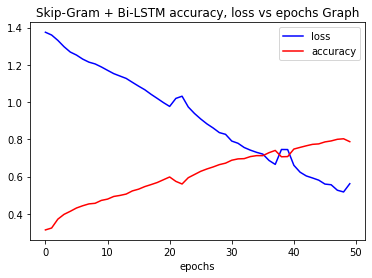

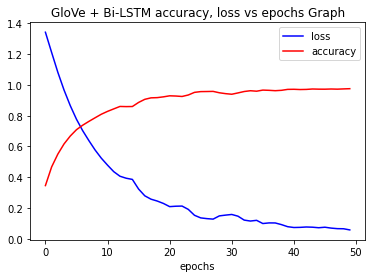

In [ ]:
print("\tLstm\t\t\tBiLstm\t\t\tRnn")
print("sg",result_table[:3])
print("cbow",result_table[3:6])
print("glove",result_table[6:9])
print(history_sg_bi.history)
plt.title("Skip-Gram + Bi-LSTM accuracy, loss vs epochs Graph")
plt.plot(history_sg_bi.history['loss'],c='b',label='loss')
plt.plot(history_sg_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()
plt.title("GloVe + Bi-LSTM accuracy, loss vs epochs Graph")
plt.plot(history_glove_bi.history['loss'],c='b',label='loss')
plt.plot(history_glove_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()